In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [3]:
from utils.data_funcs import *

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [5]:
import shap

# Model Types
1. Takes yesterday's active cases, date of year, and time since closure and predicts daily case numbers for today. Starting with an initial day seed, we can propogate forward the daily cases and analyze how different implementation dates affect case numbers.

2. Takes yesterday's active cases and time since closure and predicts daily case numbers for today. Like model type 1, we can start with an initial day seed and propogate forward the daily cases. However, here we have the notion of a general policy affect. This model can perhaps alter the initial number of cases to gauge policy effectiveness when implemented at different heights of pandemic.

# Model Training Functions

In [6]:
def cv_xgboost(input_dmatrix, full_grid):
    '''
    Takes input_dmatrix (DMatrix type with data and labels) and 
    searches over a predefined grid for optimal XGboost parameters. If 
    full_grid = True, does a more comprehensive search. This function
    returns the parameters and number of boost rounds that resulted 
    in the minimum average test RMSE at the end of training. Also returns
    the minimum average test RMSE value and error data from the whole
    minimum training run.
    '''
    # Define parameter grid
    if (full_grid):
        grid = {
            'objective': ['reg:squarederror'],
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.3, 0.6, 0.8],
            'learning_rate': [0.05, 0.1, 0.15],
            'alpha': [1, 5, 10]
        }
    else:
        grid = {
            'objective': ['reg:squarederror'],
            'min_child_weight': [5, 10],
            'gamma': [0.5, 1.5],
            'subsample': [0.6, 1.0],
            'colsample_bytree': [0.3, 0.8],
            'learning_rate': [0.05, 0.15],
            'alpha': [10]
        }
    
    param_grid = ParameterGrid(grid)
    
    # Search over parameter grid
    min_params = None
    min_final_test = None
    min_cv_results = None
    min_boost = None
    for params in list(param_grid):
        for num_bst_rnds in [25]:
            # Cross validate for optimal parameters
            cv_results = xgb.cv(dtrain=input_dmatrix, params=params, nfold=5,
                                num_boost_round=num_bst_rnds, early_stopping_rounds=10,
                                metrics="rmse", as_pandas=True, seed=123)
            if (not min_final_test) or (cv_results["test-rmse-mean"].iloc[-1] < min_final_test):
                min_final_test = cv_results["test-rmse-mean"].iloc[-1]
                min_params = params.copy()
                min_boost = num_bst_rnds
                min_cv_results = cv_results
    return min_params, min_boost, min_final_test, min_cv_results

def plot_feature_importances(xg_reg):
    """
    Plots feature importances of an XGBoost model according to metrics 
    1. Weight: The number of times a feature is used to split data across all
               trees.
    2. Gain: The number of times a feature is used to split the data across
             all trees weighted by the number of training data points that go 
             through those splits.
    3. Cover: The average training loss reduction gained when using a feature
              for splitting.
    """
    xgb.plot_importance(xg_reg)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    xgb.plot_importance(xg_reg, importance_type='gain')
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    xgb.plot_importance(xg_reg, importance_type='cover')
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()

# Model 1 Input Dataframe 

In [30]:
# Get state policy data
input_df = get_state_policy_data(fill=True)

# Keep relevant columns
policy_of_interest = POLICIES[0]
input_df = input_df[['region_name', 'date', policy_of_interest]]

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.


In [31]:
# Add days since policy change
input_df.loc[:, 'days_since_more_strict'] = time_elapsed_since_policy_change(input_df, 
                                                                             policy_of_interest,
                                                                             type_change='more_strict')

In [32]:
# Rename region_name to state
input_df.rename(columns={'region_name': 'state'}, inplace=True)

# Get US daily case data for 50 states
us_state_daily = get_state_covid_daily_data()
not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
us_state_daily_50 =  us_state_daily[~(us_state_daily.state.isin(not_states))]

In [33]:
# Merge daily cases with input df
input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date'] )

# Get cumulative cases and add as col to input df
input_df['yesterdays_active_cases'] = get_yesterdays_active_cases(input_df, window=15)

# Merge pop density with input df
input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

# Merge wage data with input df
input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

# Merge political data with input df
input_df = input_df.merge(get_political_data(), on=['state'], how='left')

In [34]:
# Adding day of year
input_df['day'] = input_df.date.dt.dayofyear + 365 * (input_df.date.dt.year - 2020)

In [35]:
# Grab time window to split training and test data
date_start = "2020-01-01"
date_end = "2020-12-31"
train_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end)].copy()
test_df = input_df.loc[(input_df['date'] > date_end)].copy()

# Drop unused cols
train_df = train_df.drop(columns=['state', 'deaths', 'date'])
test_df = test_df.drop(columns=['state', 'deaths', 'date'])

In [36]:
# Get input and output for training
x_train_df = train_df.loc[:, train_df.columns != 'cases'].copy()
y_train_df = train_df[['cases']].copy()

# Get input and output for testing
x_test_df = test_df.loc[:, test_df.columns != 'cases'].copy()
y_test_df = test_df[['cases']].copy()

# Model 1 XGBoost Training

In [38]:
# Data DMatrix is special datatype used by XGboost, quicker performance
train_data_dmatrix = xgb.DMatrix(data=x_train_df, label = y_train_df)
test_data_dmatrix = xgb.DMatrix(data=x_test_df, label = y_test_df)

In [39]:
# Gets optimal parameters via grid search and cross validation
min_params, min_boost, min_final_test, min_results = cv_xgboost(train_data_dmatrix, full_grid = False)

In [40]:
# Trains XGBoost model according to optimal parameters
xg_reg = xgb.train(params=min_params, dtrain=train_data_dmatrix, num_boost_round = min_boost)

# Model 1 Feature Importances

When plotting feature importances using XGBoost's built in method, we can see that days_since_more_strict, yesterdays_active cases, and day are used the most to split data across all trees. However, 
days_since_more_strict is rated considerably lower according to the gain and cover methods, while
yesterdays_active cases remains important. This implies that days_since_more_strict
splits are not as effective at reducing training loss, and are used less often by training data
than yesterdays_active_cases splits.

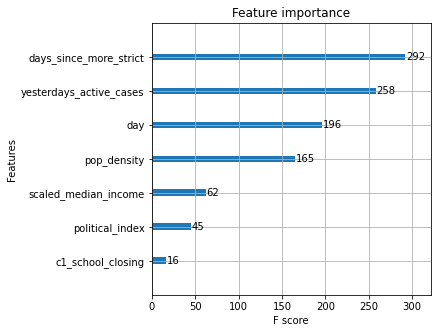

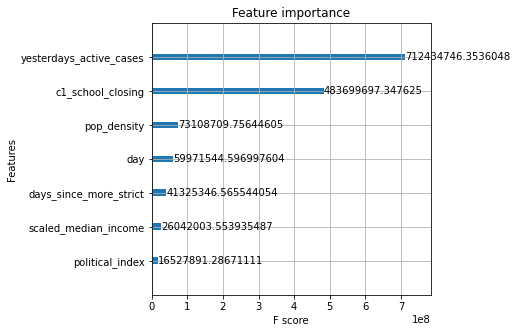

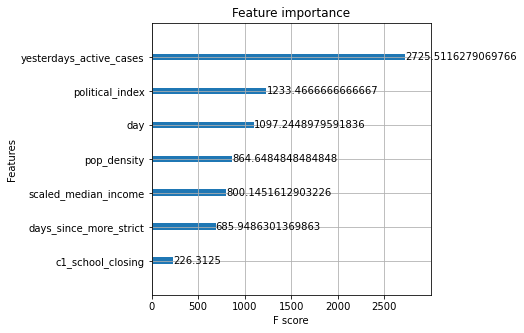

In [41]:
plot_feature_importances(xg_reg)

In [42]:
print("Final RMSE Error of Best Parameter Run: {}".format(min_final_test))
print("RMSE Error of Best Param Model on Test Set: {}".format(np.sqrt(mean_squared_error(
    y_test_df.to_numpy(), xg_reg.predict(test_data_dmatrix)))))

Final RMSE Error of Best Parameter Run: 1012.2993044000001
RMSE Error of Best Param Model on Test Set: 2427.658196400367


For further investigation, let us use the SHAP library to analyze feature importance. SHAP values characterize the effect that a particular feature has on the target variable. The first plot shows us that yesterdays_active cases has the largest average impact on the daily cases output. The second plot show in more detail that higher values of yesterdays active cases tend to increase the model output. Note that in both plots, the effect of days_since_more_strict is neglible by comparison. The third plot shows the same result.

In [43]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(x_test_df)

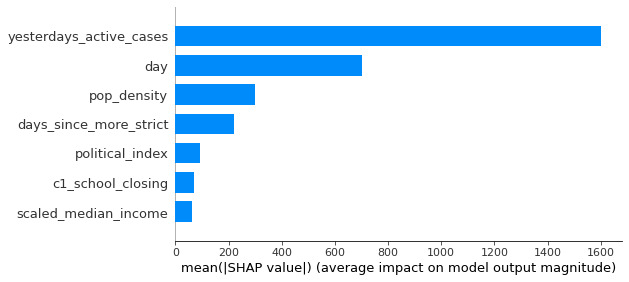

In [44]:
shap.summary_plot(shap_values, x_test_df, plot_type="bar")

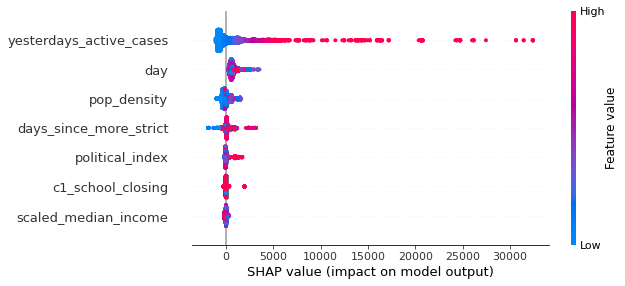

In [45]:
shap.summary_plot(shap_values, x_test_df)

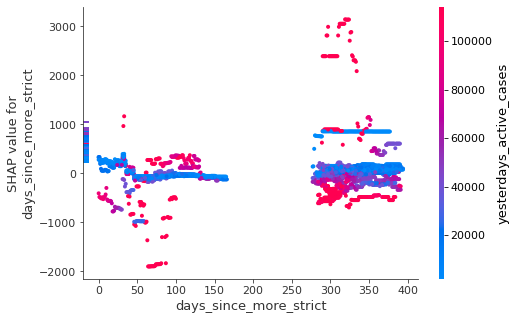

In [46]:
shap.dependence_plot("days_since_more_strict", shap_values, x_test_df)

# Model 1 Simulation

In [47]:
def get_seed_m1(state, strictness, policy_dt):
    """
    Takes a state, strictness level, and policy implementation date
    and returns an row dataframe that may be passed to the model 1
    xgboost regressor. The state's population density,
    wage, and polical features are used for features. The strictness
    level is used for the c1_school_closing feature. The policy_dt datetime
    variable is used for the day feature. The policy date and state are
    used to grab a yesterday_active_case number feature from the states
    true covid data.
    """
    covid_df = get_state_covid_daily_data()
    pop_density_df = get_pop_density_by_state_data()
    wage_df = get_scaled_wages_data()[['state', 'scaled_median_income']]
    politic_df = get_political_data().reset_index()
    
    seed_pd = pop_density_df.loc[pop_density_df['state'] == state]['pop_density'].iloc[0]
    seed_wage = wage_df.loc[wage_df['state'] == state]['scaled_median_income'].iloc[0]
    seed_pol = politic_df.loc[politic_df['state'] == state]['political_index'].iloc[0]
    
    imp_day = policy_dt.dayofyear
    initial_cases = list(covid_df.loc[(covid_df.state == 'California') & 
                                      (covid_df.date >= policy_dt - pd.Timedelta(days=15)) & 
                                      (covid_df.date < policy_dt)].cases.values)
    act_cases = sum(initial_cases)
    days_since = 0
    
    seed = pd.DataFrame([strictness, days_since, act_cases, seed_pd, seed_wage, seed_pol, imp_day]).T
    seed.columns = ['c1_school_closing', 'days_since_more_strict',
                    'yesterdays_active_cases', 'pop_density', 
                    'scaled_median_income', 'political_index', 'day']
    
    return seed
    
def sim_m1(xgb_model, params):
    """
    Takes a Model 1 XGBoost model 'xgb_model' and 
    list of dictionaries 'params' where each dictionary
    contains {num_days_sim, strictness, policy_day, state}
    Iterates over params and runs a simulation for each, 
    with number of days to simulate being 'num_days_sim'.
    
    This function simulates daily covid cases after 'policy_day' in 'state'
    if school closure policy was enacted on that date with 'strictness'. To do this,
    it first constructs a seed day with appropriate features, and then simulates
    new daily case numbers via the XGBoost model 'xgb_model'. Predicted values are then plotted
    next to the true values for 'state' after 'policy_day'.
    """
    fig = plt.figure(figsize=(10, 10))
    p_dates = []
    
    for param in params:
        policy_day = param['policy_day']
        state = param['state']
        strictness = param['strictness']
        num_days_sim = param['num_days_sim']
        
        policy_dt = pd.to_datetime(policy_day)
        p_dates.append(policy_dt.dayofyear)

        seed = get_seed_m1(state, strictness, policy_dt)

        covid_df = get_state_covid_daily_data()

        results = list(covid_df.loc[(covid_df.state == state) & 
                      (covid_df.date >= policy_dt - pd.Timedelta(days=15)) &
                      (covid_df.date < policy_dt)]['cases'].values)
        days = list(range(int(seed['day'].iloc[0]) - 15, int(seed['day'].iloc[0])))
        curr_day = seed.copy()
        case_window = results.copy()

        for i in range(num_days_sim):
            new_cases = xgb_model.predict(xgb.DMatrix(data=curr_day))[0]
            case_window.append(new_cases)
            results.append(new_cases)
            curr_day['yesterdays_active_cases'] = (curr_day.loc[0, 'yesterdays_active_cases'] - 
                                                   case_window.pop(0) + new_cases)

            days.append(curr_day.loc[0, 'day'])
            curr_day['day'] = curr_day.loc[0, 'day'] + 1
            if strictness != 0:
                curr_day['days_since_more_strict'] = curr_day.loc[0, 'days_since_more_strict'] + 1


        plt.plot(days, results, label = 'Simulated Level {} Closure on {}'.format(strictness, policy_day))
        
    window_start = min(p_dates) - 15
    window_end = max(p_dates) + num_days_sim

    plt.plot(list(range(window_start, window_end)), 
             covid_df.loc[(covid_df.state == state) & 
                        (covid_df.date.dt.dayofyear >= window_start) & 
                        (covid_df.date.dt.dayofyear < window_end) &
                         (covid_df.date.dt.year == 2020)]['cases'], 
             label = 'Real Closure on 2020-03-07')
    
    plt.title('{} Daily Cases over time'.format(state))
    plt.xlabel('Day of Year')
    plt.ylabel('Covid Daily Cases')
    plt.legend()

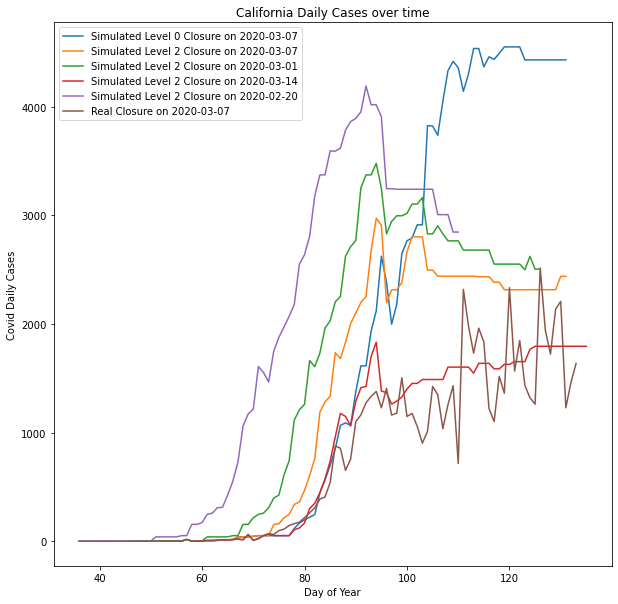

In [49]:
# Sanity Check: Should simulate not policy enacted. Covid numbers should be higher.
# Actual policy_day for school closures in California : "2020-03-07"
sim_m1(xg_reg, [{'num_days_sim': 65, 'strictness': 0, 'policy_day': "2020-03-07", 'state': "California"},
                {'num_days_sim': 65, 'strictness': 2, 'policy_day': "2020-03-07", 'state': "California"},
                {'num_days_sim': 66, 'strictness': 2, 'policy_day': "2020-03-01", 'state': "California"},
                {'num_days_sim': 62, 'strictness': 2, 'policy_day': "2020-03-14", 'state': "California"},
                {'num_days_sim': 60, 'strictness': 2, 'policy_day': "2020-02-20", 'state': "California"}
               ])

# Model 1 Conclusion
Model 1 accurately predicts training and test data. Below you can see a plot of its predictions (blue) for daily covid cases in California over the course of the pandemic vs true values (orange). However,
the importance it places on yesterdays active cases is so large that any policy analysis via simulation
on the days_since_more_strict parameter is difficult. Initial simulation shows interesting results, and offers some insights on potential improvements. Indeed, it may be useful to try to make day_since_more_strict a stronger feature of the model. Note that each simulation takes a significant dip in case numbers around day 90, regardless of implementation date. Perhaps we can fiddle with the day feature or replace it altogether.

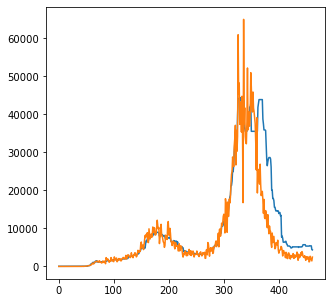

In [53]:
plt.plot(xg_reg.predict(xgb.DMatrix(data=input_df.loc[input_df['state'] == 'California'].drop(columns=['state', 'deaths', 'date', 'cases']))))
plt.plot(list(range(len(input_df.loc[input_df['state'] == 'California']['cases']))), 
         input_df.loc[input_df['state'] == 'California']['cases'])

# Model 2 Input Dataframe

In [55]:
# Get state policy data
input_df = get_state_policy_data(fill=True)

# Keep relevant columns
policy_of_interest = POLICIES[0]
input_df = input_df[['region_name', 'date', policy_of_interest]]

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.


In [56]:
# Add days since policy change
input_df.loc[:, 'days_since_more_strict'] = time_elapsed_since_policy_change(input_df, 
                                                                             policy_of_interest,
                                                                             type_change='more_strict')

In [57]:
# Rename region_name to state
input_df.rename(columns={'region_name': 'state'}, inplace=True)

# Get US daily case data for 50 states
us_state_daily = get_state_covid_daily_data()
not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
us_state_daily_50 =  us_state_daily[~(us_state_daily.state.isin(not_states))]

In [58]:
# Merge daily cases with input df
input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date'] )

# Get cumulative cases and add as col to input df
input_df['yesterdays_active_cases'] = get_yesterdays_active_cases(input_df, window=15)

# input_df['future_cases'] = get_future_cum_cases(input_df, window=30)

# Merge pop density with input df
input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

# Merge mobility data with input df
# input_df = input_df.merge(get_at_away_6_data(), on=['date', 'state'], how='left')

# Merge wage data with input df
input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

# Merge political data with input df
input_df = input_df.merge(get_political_data(), on=['state'], how='left')

In [59]:
# Grab time window to split training and test data
date_start = "2020-01-01"
date_end = "2020-12-31"
# test_states = list(input_df.state.unique())[1:16]
# train_df = input_df.loc[(input_df['date'] >= date_start) & 
#                         (input_df['date'] <= date_end) &
#                         (~input_df.state.isin(test_states))].copy()
# test_df = input_df.loc[(input_df['date'] >= date_start) & 
#                         (input_df['date'] <= date_end) &
#                         (input_df.state.isin(test_states))].copy()

train_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end)].copy()
test_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end)].copy()

# test_df = input_df.loc[(input_df['date'] > date_end)].copy()

# Drop unused cols
train_df = train_df.drop(columns=['state', 'deaths', 'date'])
test_df = test_df.drop(columns=['state', 'deaths', 'date'])

In [60]:
# Get input and output for training
x_train_df = train_df.loc[:, train_df.columns != 'cases'].copy()
y_train_df = train_df[['cases']].copy()

# Get input and output for testing
x_test_df = test_df.loc[:, test_df.columns != 'cases'].copy()
y_test_df = test_df[['cases']].copy()

# Model 2 XGBoost Training

In [61]:
# Data DMatrix is special datatype used by XGboost, quicker performance
train_data_dmatrix = xgb.DMatrix(data=x_train_df, label = y_train_df)
test_data_dmatrix = xgb.DMatrix(data=x_test_df, label = y_test_df)

In [62]:
min_params, min_boost, min_final_test, min_results = cv_xgboost(train_data_dmatrix, full_grid = False)

In [63]:
xg_reg = xgb.train(params=min_params, dtrain=train_data_dmatrix, num_boost_round = min_boost)

# Model 1 Feature Importances

When plotting feature importances using XGBoost's built in method, we can see that days_since_more_strict and yesterdays_active cases are used the most to split data across all trees. However, 
days_since_more_strict is rated considerably lower according to the gain and cover methods, while
yesterdays_active cases remains important. This implies that days_since_more_strict
splits are not as effective at reducing training loss, and are used less often by training data
than yesterdays_active_cases splits. This behavior mimics that of Model 1, although it can be said that overall, yesterdays_active_cases and the other features are closer in importance.

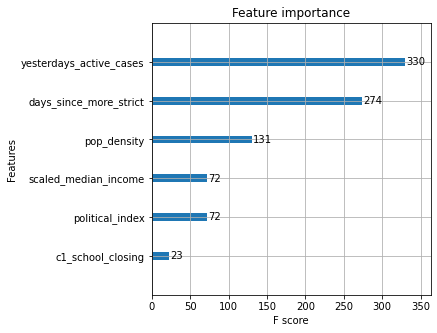

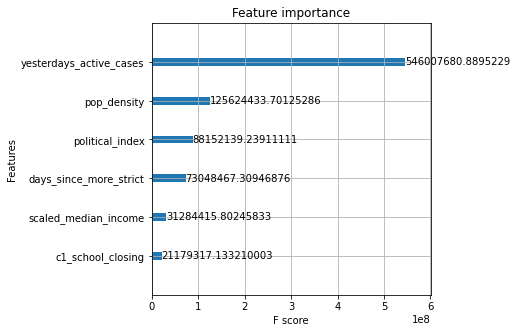

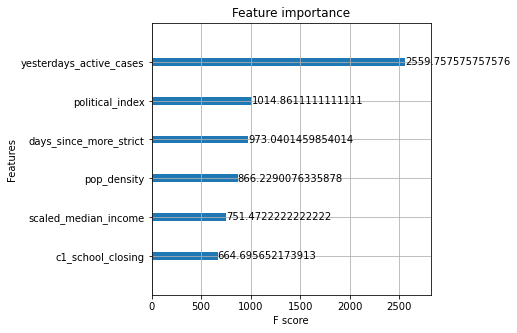

In [64]:
plot_feature_importances(xg_reg)

In [65]:
print("RMSE Error of Best Parameter Run: {}".format(min_final_test))
print("RMSE Error of Best Param Model on Test Set: {}".format(np.sqrt(mean_squared_error(
    y_test_df.to_numpy(), xg_reg.predict(test_data_dmatrix)))))

RMSE Error of Best Parameter Run: 1022.8547606
RMSE Error of Best Param Model on Test Set: 914.3787416868711


For further investigation, let us use the SHAP library to analyze feature importance. SHAP values characterize the effect that a particular feature has on the target variable. The first plot shows us that yesterdays_active cases has the largest average impact on the daily cases output. This behavior is once again similar to Model 1, but it should be noted that the relative impact of yesterdays_active_cases has become more comparable to other features. The second plot show in more detail that higher values of yesterdays active cases tend to increase the model output. Moreover, day_since_more_strict has become the second most important feature. The third plot shows that when yesterdays active cases are between 20000 and 30000, days_since_more_strict has a neglible effect.

In [66]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(x_test_df)

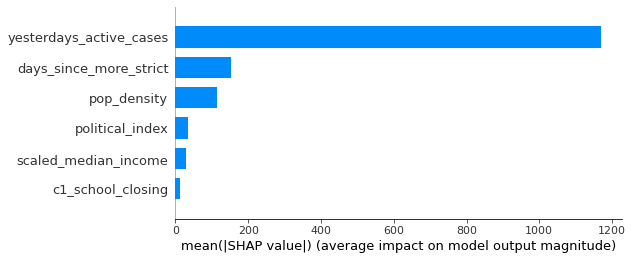

In [67]:
shap.summary_plot(shap_values, x_test_df, plot_type="bar")

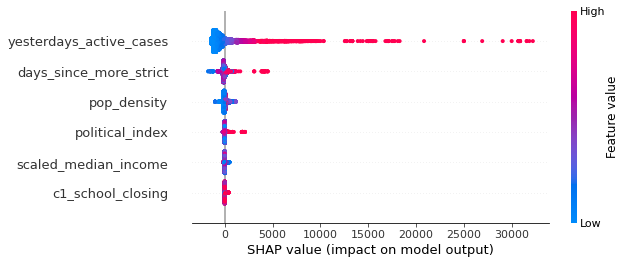

In [68]:
shap.summary_plot(shap_values, x_test_df)

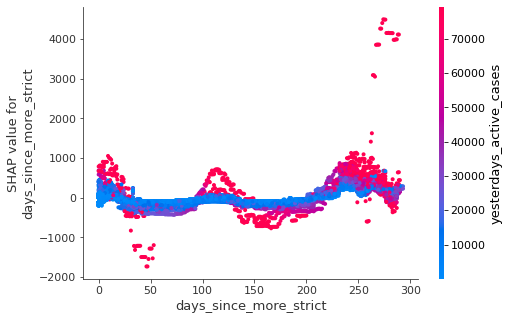

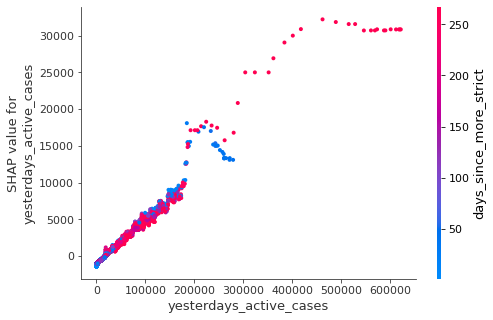

In [69]:
shap.dependence_plot("days_since_more_strict", shap_values, x_test_df)
shap.dependence_plot("yesterdays_active_cases", shap_values, x_test_df)

# Model 2 Simulation

In [70]:
def get_seed_m2(state, strictness, policy_dt):
    """
    Takes a state, strictness level, and policy implementation date
    and returns an row dataframe that may be passed to the model 1
    xgboost regressor. The state's population density,
    wage, and polical features are used for features. The strictness
    level is used for the c1_school_closing feature. The policy_dt datetime
    variable is used for the day feature. The policy date and state are
    used to grab a yesterday_active_case number feature from the states
    true covid data.
    """
    covid_df = get_state_covid_daily_data()
    pop_density_df = get_pop_density_by_state_data()
    wage_df = get_scaled_wages_data()[['state', 'scaled_median_income']]
    politic_df = get_political_data().reset_index()
    
    seed_pd = pop_density_df.loc[pop_density_df['state'] == state]['pop_density'].iloc[0]
    seed_wage = wage_df.loc[wage_df['state'] == state]['scaled_median_income'].iloc[0]
    seed_pol = politic_df.loc[politic_df['state'] == state]['political_index'].iloc[0]
    
    initial_cases = list(covid_df.loc[(covid_df.state == state) & 
                                      (covid_df.date >= policy_dt - pd.Timedelta(days=15)) & 
                                      (covid_df.date < policy_dt)].cases.values)
    act_cases = sum(initial_cases)
    days_since = 0
    
    seed = pd.DataFrame([strictness, days_since, act_cases, seed_pd, seed_wage, seed_pol]).T
    seed.columns = ['c1_school_closing', 'days_since_more_strict',
                    'yesterdays_active_cases', 'pop_density', 
                    'scaled_median_income', 'political_index']
    
    return seed
    
def sim_m2(xgb_model, params, true_policy_day):
    """
    Takes a Model 1 XGBoost model 'xgb_model' and 
    list of dictionaries 'params' where each dictionary
    contains {num_days_sim, strictness, policy_day, state}
    Iterates over params and runs a simulation for each, 
    with number of days to simulate being 'num_days_sim'.
    
    This function simulates daily covid cases after 'policy_day' in 'state'
    if school closure policy was enacted on that date with 'strictness'. To do this,
    it first constructs a seed day with appropriate features, and then simulates
    new daily case numbers via the XGBoost model 'xgb_model'. Predicted values are then plotted
    next to the true values for 'state' after 'policy_day'.
    """
    fig = plt.figure(figsize=(10, 10))
    p_dates = []
    
    for param in params:
        policy_day = param['policy_day']
        state = param['state']
        strictness = param['strictness']
        num_days_sim = param['num_days_sim']
        
        policy_dt = pd.to_datetime(policy_day)
        p_dates.append(policy_dt.dayofyear)

        seed = get_seed_m2(state, strictness, policy_dt)

        covid_df = get_state_covid_daily_data()

        results = list(covid_df.loc[(covid_df.state == state) & 
                      (covid_df.date >= policy_dt - pd.Timedelta(days=15)) &
                      (covid_df.date < policy_dt)]['cases'].values)
        days = list(range(int(policy_dt.dayofyear) - 15, int(policy_dt.dayofyear)))
        day = policy_dt.dayofyear
        curr_day = seed.copy()
        case_window = results.copy()

        for i in range(num_days_sim):
            new_cases = xgb_model.predict(xgb.DMatrix(data=curr_day))[0]
            case_window.append(new_cases)
            results.append(new_cases)
            curr_day['yesterdays_active_cases'] = (curr_day.loc[0, 'yesterdays_active_cases'] - 
                                                   case_window.pop(0) + new_cases)

            days.append(day)
            day += 1
            if strictness != 0:
                curr_day['days_since_more_strict'] = curr_day.loc[0, 'days_since_more_strict'] + 1


        plt.plot(days, results, label = 'Simulated Level {} Closure on {}'.format(strictness, policy_day))
        
    window_start = min(p_dates) - 15
    window_end = max(p_dates) + num_days_sim

    plt.plot(list(range(window_start, window_end)), 
             covid_df.loc[(covid_df.state == state) & 
                        (covid_df.date.dt.dayofyear + 366 * (covid_df.date.dt.year - 2020) >= window_start) & 
                        (covid_df.date.dt.dayofyear + 366 * (covid_df.date.dt.year - 2020) < window_end)
                         ]['cases'], 
             label = 'Real Closure on {}'.format(true_policy_day))
    
    plt.title('{} Daily Cases over time'.format(state))
    plt.xlabel('Day of Year')
    plt.ylabel('Covid Daily Cases')
    plt.legend()

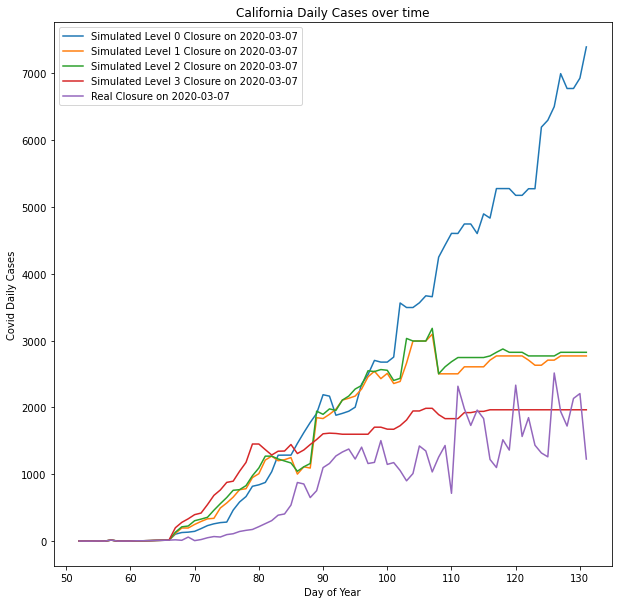

In [71]:
sim_m2(xg_reg, [{'num_days_sim': 65, 'strictness': 0, 'policy_day': "2020-03-07", 'state': "California"},
                {'num_days_sim': 65, 'strictness': 1, 'policy_day': "2020-03-07", 'state': "California"},
                {'num_days_sim': 65, 'strictness': 2, 'policy_day': "2020-03-07", 'state': "California"},
                {'num_days_sim': 65, 'strictness': 3, 'policy_day': "2020-03-07", 'state': "California"}
               ],
      "2020-03-07")

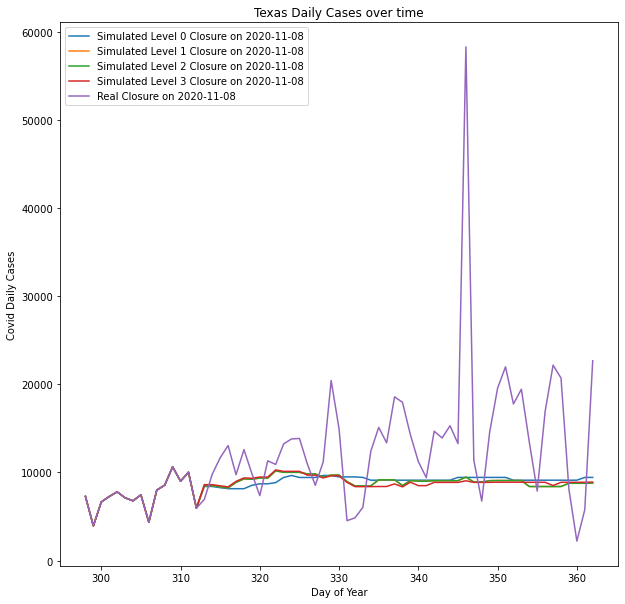

In [72]:
sim_m2(xg_reg, [{'num_days_sim': 50, 'strictness': 0, 'policy_day': "2020-11-08", 'state': "Texas"},
                {'num_days_sim': 50, 'strictness': 1, 'policy_day': "2020-11-08", 'state': "Texas"},
                {'num_days_sim': 50, 'strictness': 2, 'policy_day': "2020-11-08", 'state': "Texas"},
                {'num_days_sim': 50, 'strictness': 3, 'policy_day': "2020-11-08", 'state': "Texas"}
               ],
      "2020-11-08")

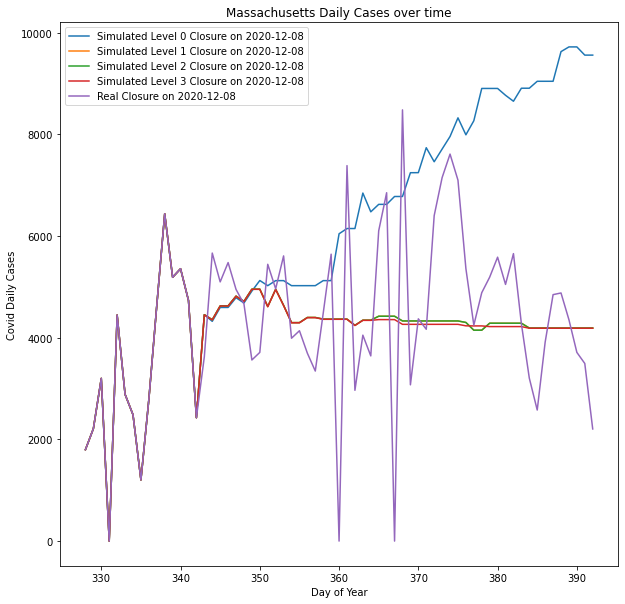

In [73]:
sim_m2(xg_reg, [{'num_days_sim': 50, 'strictness': 0, 'policy_day': "2020-12-08", 'state': "Massachusetts"},
                {'num_days_sim': 50, 'strictness': 1, 'policy_day': "2020-12-08", 'state': "Massachusetts"},
                {'num_days_sim': 50, 'strictness': 2, 'policy_day': "2020-12-08", 'state': "Massachusetts"},
                {'num_days_sim': 50, 'strictness': 3, 'policy_day': "2020-12-08", 'state': "Massachusetts"}
               ],
      "2020-12-08")

# Model 2 Conclusion
TODO

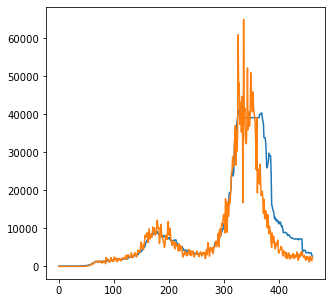

In [75]:
plt.plot(xg_reg.predict(xgb.DMatrix(data=input_df.loc[input_df['state'] == 'California'].drop(columns=['state', 'deaths', 'date', 'cases']))))
plt.plot(list(range(len(input_df.loc[input_df['state'] == 'California']['cases']))), 
         input_df.loc[input_df['state'] == 'California']['cases'])

# Model 3

Features: past 4 weeks cases, politic, pop density, strictness, income, season, is_holiday_soon, mobility 
Output: next 4 week cases

In [76]:
# Get state policy data
input_df = get_state_policy_data(fill=True)

# Keep relevant columns
policy_of_interest = POLICIES[0]
input_df = input_df[['region_name', 'date', policy_of_interest]]

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.


In [77]:
# Rename region_name to state
input_df.rename(columns={'region_name': 'state'}, inplace=True)

# Get US daily case data for 50 states
us_state_daily = get_state_covid_daily_data()
not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
us_state_daily_50 = us_state_daily[~(us_state_daily.state.isin(not_states))]

In [78]:
# Merge daily cases with input df
input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date'] )

# Get cumulative cases and add as col to input df
input_df['past_month_cases'] = get_yesterdays_active_cases(input_df, window=28)
input_df['future_month_cases'] = get_future_cum_cases(input_df, window=28)

# Merge pop density with input df
input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

# Merge mobility data with input df
input_df = input_df.merge(get_at_away_6_data(), on=['date', 'state'], how='left')

# Merge wage data with input df
input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

# Merge political data with input df
input_df = input_df.merge(get_political_data(), on=['state'], how='left')

In [79]:
# Get seasons and add as column to input df
input_df['seasons'] = month_to_season_num(input_df)
input_df = input_df.merge(get_binary_encoded_seasons(), on=['seasons'], how='left')
input_df = input_df.drop(columns=['seasons']) 

# Check if dates are close to a holiday and add as column
input_df['close_to_holiday'] = get_close_to_holiday(input_df)

In [80]:
running_df = None
for name_df, df in input_df.groupby(['state']):
    diffs = df[policy_of_interest].diff()
    diffs.iloc[0] = df[policy_of_interest].iloc[0]
    
    diffs = diffs > 0
    if running_df is None:
        running_df = diffs.copy()
    else:
        running_df = pd.concat([running_df, diffs], ignore_index = False, axis = 0)
        
policy_change_df = running_df.copy()

In [81]:
input_df = input_df[policy_change_df].copy()

In [82]:
# Split training and test data
train_df, test_df = train_test_split(input_df, test_size=0.2)

# Drop unused cols
train_df = train_df.drop(columns=['state', 'deaths', 'date', 'cases'])
test_df = test_df.drop(columns=['state', 'deaths', 'date', 'cases'])

In [83]:
# Get input and output for training
x_train_df = train_df.loc[:, train_df.columns != 'future_month_cases'].copy()
y_train_df = train_df[['future_month_cases']].copy()

# Get input and output for testing
x_test_df = test_df.loc[:, test_df.columns != 'future_month_cases'].copy()
y_test_df = test_df[['future_month_cases']].copy()

# Model 3 XGBoost Training

In [84]:
# Data DMatrix is special datatype used by XGboost, quicker performance
train_data_dmatrix = xgb.DMatrix(data=x_train_df, label = y_train_df)
test_data_dmatrix = xgb.DMatrix(data=x_test_df, label = y_test_df)

In [85]:
min_params, min_boost, min_final_test, min_results = cv_xgboost(train_data_dmatrix, full_grid = True)

In [86]:
xg_reg = xgb.train(params=min_params, dtrain=train_data_dmatrix, num_boost_round = min_boost)

# Model 1 Feature Importances

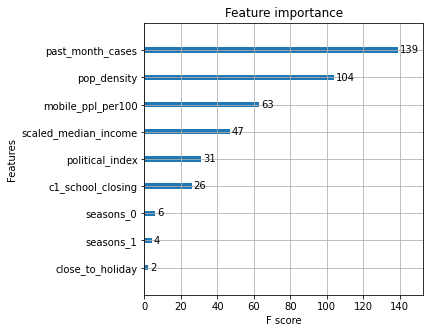

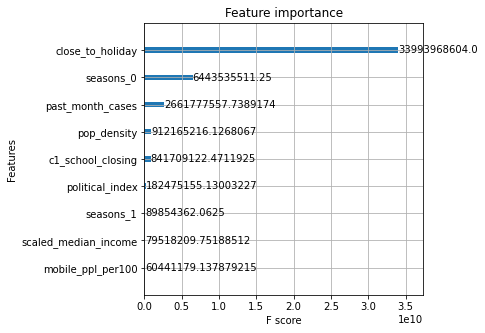

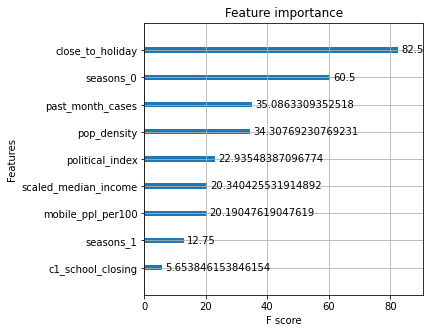

In [87]:
plot_feature_importances(xg_reg)

Text(0.5, 1.0, 'XGBoost Training Predictions vs Real Values')

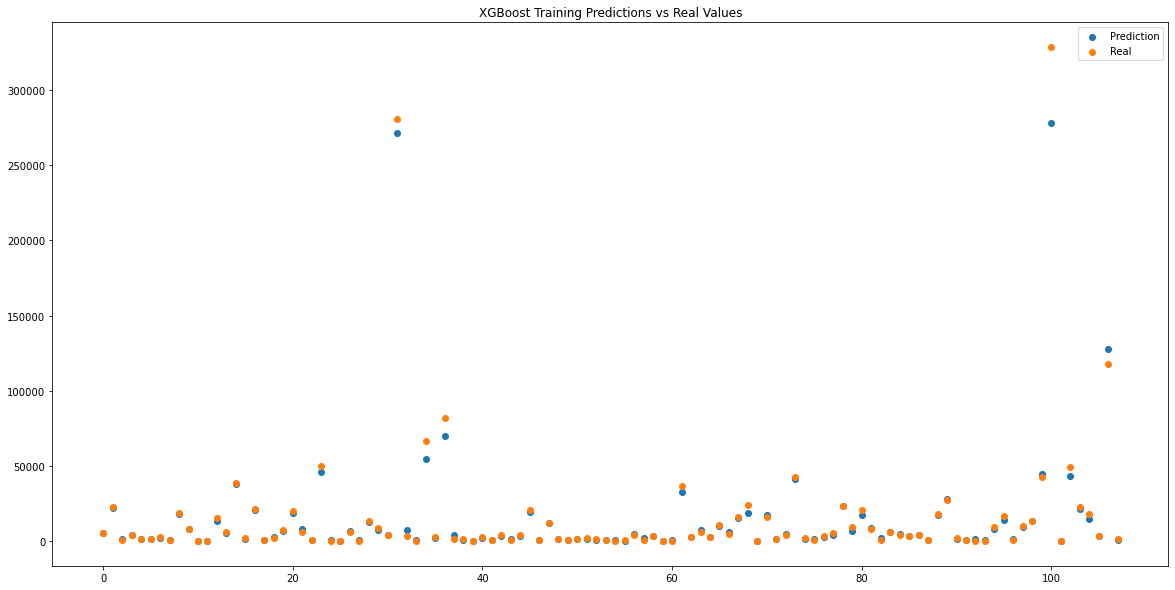

In [88]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(list(range(0, len(y_train_df))), xg_reg.predict(train_data_dmatrix), label = 'Prediction')
plt.scatter(list(range(0, len(y_train_df))), y_train_df, label = 'Real')
plt.legend()
plt.title("XGBoost Training Predictions vs Real Values")

In [89]:
print("RMSE Error of Best Parameter Run: {}".format(min_final_test))
print("RMSE Error of Best Param Model on Test Set: {}".format(np.sqrt(mean_squared_error(
    y_test_df.to_numpy(), xg_reg.predict(test_data_dmatrix)))))

RMSE Error of Best Parameter Run: 22560.4492186
RMSE Error of Best Param Model on Test Set: 49959.507643675846


In [90]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(x_test_df)

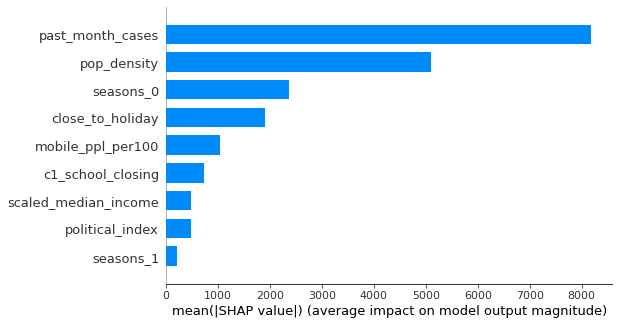

In [91]:
shap.summary_plot(shap_values, x_test_df, plot_type="bar")

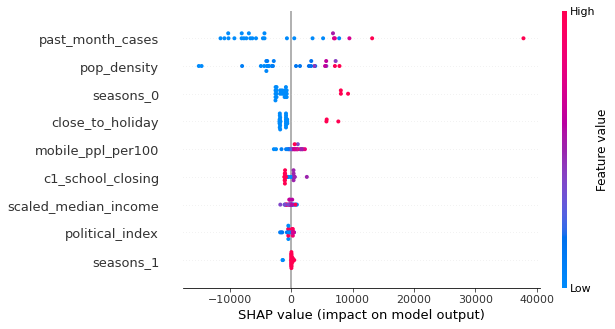

In [92]:
shap.summary_plot(shap_values, x_test_df)

(array([97.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

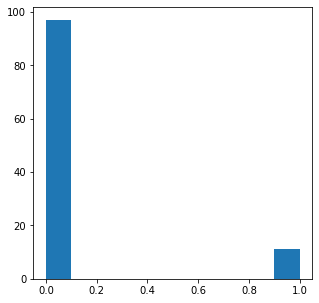

In [93]:
plt.hist(x_train_df['close_to_holiday'])

(array([99.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

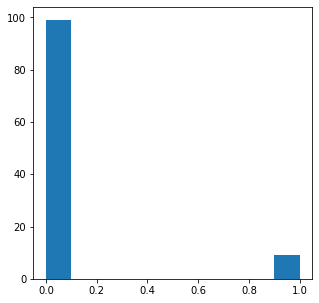

In [94]:
plt.hist(x_train_df['seasons_0'])

# Model 3 Simulation

In [95]:
def get_seed_m3(state, strictness, policy_dt, season, holiday):
    """
    """
    covid_df = get_state_covid_daily_data()
    covid_df['past_month_cases'] = get_yesterdays_active_cases(covid_df, window=28)
    
    pop_density_df = get_pop_density_by_state_data()
    wage_df = get_scaled_wages_data()[['state', 'scaled_median_income']]
    politic_df = get_political_data().reset_index()
    mobility_df = get_at_away_6_data()
    season_df = get_binary_encoded_seasons()
    
    seed_pd = pop_density_df.loc[pop_density_df['state'] == state]['pop_density'].iloc[0]
    seed_wage = wage_df.loc[wage_df['state'] == state]['scaled_median_income'].iloc[0]
    seed_pol = politic_df.loc[politic_df['state'] == state]['political_index'].iloc[0]
    
    seed_mob = mobility_df.loc[(mobility_df['state'] == state) &
                               (mobility_df['date'] == policy_dt)]['mobile_ppl_per100'].iloc[0]
    seed_cases = covid_df.loc[(covid_df['state'] == state) &
                              (covid_df['date'] == policy_dt)]['past_month_cases'].iloc[0]
    
    seed_season_0 = season_df.loc[season_df['seasons'] == season]['seasons_0'].iloc[0]
    seed_season_1 = season_df.loc[season_df['seasons'] == season]['seasons_1'].iloc[0]
    
    seed = pd.DataFrame([strictness, seed_cases, seed_pd, seed_mob, 
                         seed_wage, seed_pol, seed_season_0, seed_season_1, holiday]).T
    seed.columns = ['c1_school_closing', 'past_month_cases', 'pop_density',
                    'mobile_ppl_per100', 'scaled_median_income', 'political_index',
                    'seasons_0', 'seasons_1', 'close_to_holiday']
    return seed.apply(pd.to_numeric)
    
def sim_m3(xgb_model, params):
    """
    """
    
    covid_df = get_state_covid_daily_data()
    covid_df['past_month_cases'] = get_yesterdays_active_cases(covid_df, window=28)
    covid_df['future_month_cases'] = get_future_cum_cases(covid_df, window=28)
    
    for param in params:
        policy_day = param['policy_day']
        state = param['state']
        strictness = param['strictness']
        season = param['season']
        holiday = param['holiday']
        
        policy_dt = pd.to_datetime(policy_day)

        seed = get_seed_m3(state, strictness, policy_dt, season, holiday)

        past_cases = covid_df.loc[(covid_df['state'] == state) &
                                  (covid_df['date'] == policy_dt)]['past_month_cases'].iloc[0]
        future_cases = covid_df.loc[(covid_df['state'] == state) &
                                  (covid_df['date'] == policy_dt)]['future_month_cases'].iloc[0]
        predict_cases = xgb_model.predict(xgb.DMatrix(data=seed))[0]
        
        print("*****Simulation Parameters*****\n")
        print("State: {}\nPolicy Date: {}\nStrictness: {}\nHoliday: {}\nSeason: {}".format(state, policy_day, strictness, holiday, season))
        print("Past Month Cases: {} \nReal Future Month Cases: {} \nPredicted Future Month Cases: {}".format(past_cases, future_cases, predict_cases))

In [97]:
sim_m3(xg_reg, [{'policy_day': '2020-10-28', 'state': 'Wyoming', 'strictness': '0', 'season': 3, 'holiday': 1},
                {'policy_day': '2020-10-28', 'state': 'Wyoming', 'strictness': '1', 'season': 3, 'holiday': 1},
                {'policy_day': '2020-10-28', 'state': 'Wyoming', 'strictness': '2', 'season': 3, 'holiday': 1}])

*****Simulation Parameters*****

State: Wyoming
Policy Date: 2020-10-28
Strictness: 0
Holiday: 1
Season: 3
Past Month Cases: 5994.0 
Real Future Month Cases: 18198.0 
Predicted Future Month Cases: 17351.87890625
*****Simulation Parameters*****

State: Wyoming
Policy Date: 2020-10-28
Strictness: 1
Holiday: 1
Season: 3
Past Month Cases: 5994.0 
Real Future Month Cases: 18198.0 
Predicted Future Month Cases: 17351.87890625
*****Simulation Parameters*****

State: Wyoming
Policy Date: 2020-10-28
Strictness: 2
Holiday: 1
Season: 3
Past Month Cases: 5994.0 
Real Future Month Cases: 18198.0 
Predicted Future Month Cases: 17351.87890625
